<a href="https://colab.research.google.com/github/deepanshu1999/Image_Captioning/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deepanshu1999","key":"655ba08b915c01fb24b4a55a6bfc6d49"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 910, in dataset_list_cli
    tag_ids, search, user, mine, page)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 880, in dataset_list
    return [Dataset(d) for d in datasets_list_result]
  File "/usr/local/lib/python2.7/dist-packages/kaggle/models/kaggle_models_extended.py", line 66, in __init__
    self.size = File.get_size(self.totalBytes)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/models/kaggle_models_extended.py", line 97, in get_size
    return '%.*f%s' % (precision, size, suffixes[suffix_index])
TypeError: float argument required, not NoneType


In [0]:
!kaggle datasets download -d cfpb/us-consumer-finance-complaints
!ls

 86% 73.0M/84.5M [00:01<00:00, 51.4MB/s]
100% 84.5M/84.5M [00:01<00:00, 75.8MB/s]
kaggle.json  sample_data  us-consumer-finance-complaints.zip


In [5]:
!kaggle datasets download -d hsankesara/flickr-image-dataset
!ls


100% 8.16G/8.16G [03:07<00:00, 38.8MB/s]
100% 8.16G/8.16G [03:07<00:00, 46.6MB/s]
flickr-image-dataset.zip  kaggle.json  sample_data


In [6]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "flickr-image-dataset.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
flickr30k_images/flickr30k_images/1000092795.jpg 2019-10-01 13:19:22       218143
flickr30k_images/flickr30k_images/10002456.jpg 2019-10-01 13:19:22       113525
flickr30k_images/flickr30k_images/1000268201.jpg 2019-10-01 13:19:22       199606
flickr30k_images/flickr30k_images/1000344755.jpg 2019-10-01 13:19:22       154005
flickr30k_images/flickr30k_images/1000366164.jpg 2019-10-01 13:19:22       103316
flickr30k_images/flickr30k_images/1000523639.jpg 2019-10-01 13:19:22       150334
flickr30k_images/flickr30k_images/1000919630.jpg 2019-10-01 13:19:22       117183
flickr30k_images/flickr30k_images/10010052.jpg 2019-10-01 13:19:22        44514
flickr30k_images/flickr30k_images/1001465944.jpg 2019-10-01 13:19:24       141082
flickr30k_images/flickr30k_images/1001545525.jpg 2019-10-01 13:19:24        86149
flickr30k_images/flickr30k_images/1001573224.jpg 2019-10-01 13:19:24       100421
flickr30k_images/flick

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done!


In [7]:
import pandas as pd
filename="flickr30k_images/results.csv"
data=pd.read_csv(filename,sep='|')
print(data.columns)
data.head()

Index(['image_name', ' comment_number', ' comment'], dtype='object')


image_name  ...                                            comment
0  1000092795.jpg  ...   Two young guys with shaggy hair look at their...
1  1000092795.jpg  ...   Two young , White males are outside near many...
2  1000092795.jpg  ...   Two men in green shirts are standing in a yard .
3  1000092795.jpg  ...       A man in a blue shirt standing in a garden .
4  1000092795.jpg  ...            Two friends enjoy time spent together .

[5 rows x 3 columns]

In [0]:
descriptions=dict()
for i in range(data.shape[0]):
  image_name=data.iloc[i][0]
  comment=data.iloc[i][2]
  image_name=image_name.split('.')[0]
  #print(image_name,comment)
  if image_name not in descriptions:
    descriptions[image_name]=[comment]
  else:
    descriptions[image_name].append(comment)
#print(descriptions)

In [9]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# prepare translation table for removing punctuation
import math
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
  #print(key,desc_list)
  for i in range(len(desc_list)):
    desc = desc_list[i]
        # tokenize
    if(isinstance(desc,float)==False):
      desc = desc.split()
        # convert to lower case
      desc = [word.lower() for word in desc]
        # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
        # store as string
      desc_list[i] =  ' '.join(desc)
    else:
      desc_list.pop(i)

In [11]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 19735


In [12]:
all_train_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('preprocessed words %d ' %len(vocab))

preprocessed words 5435 


In [13]:
descriptions['1000092795']

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young white males are outside near many bushes',
 'two men in green shirts are standing in yard',
 'man in blue shirt standing in garden',
 'two friends enjoy time spent together']

In [0]:
for i in descriptions.keys():
  for j in range(len(descriptions[i])):
    descriptions[i][j]='startseq '+descriptions[i][j]+' endseq'


In [15]:
descriptions['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [16]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)














96116736/96112376 [==============================] - 1s 0us/step


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec
#train_img=[]
#for i in descriptions.keys():
#  train_img.append('flickr30k_images/flickr30k_images/flickr30k_images/'+i+'.jpg')

In [25]:
start = time()
encoding_train = {}
count=0
for img in descriptions.keys():
    encoding_train[img] = encode('flickr30k_images/flickr30k_images/flickr30k_images/'+img+'.jpg')
    if(count%100==0):
      print((count/len(descriptions.keys())*100))
    count+=1
print("Time taken in seconds =", time()-start)

0.0
0.3146336091621307
0.6292672183242614
0.943900827486392
1.2585344366485227
1.5731680458106534
1.887801654972784
2.2024352641349147
2.5170688732970454
2.831702482459176
3.146336091621307
3.4609697007834375
3.775603309945568
4.090236919107699
4.4048705282698295
4.719504137431961
5.034137746594091
5.348771355756222
5.663404964918352
5.978038574080483
6.292672183242614
6.607305792404744
6.921939401566875
7.236573010729005
7.551206619891136
7.865840229053267
8.180473838215399
8.495107447377528
8.809741056539659
9.12437466570179
9.439008274863921
9.75364188402605
10.068275493188182
10.382909102350313
10.697542711512444
11.012176320674575
11.326809929836704
11.641443538998836
11.956077148160967
12.270710757323098
12.585344366485227
12.899977975647358
13.214611584809488
13.52924519397162
13.84387880313375
14.158512412295881
14.47314602145801
14.787779630620143
15.102413239782273
15.417046848944405
15.731680458106535
16.046314067268668
16.360947676430797
16.675581285592926
16.99021489475505

In [0]:
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [29]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=31783


In [31]:
all_train_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

158914

In [32]:
all_train_captions[2]

'startseq two men in green shirts are standing in yard endseq'

In [33]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 19737 -> 5437


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [35]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

5438

In [37]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(descriptions)
print('Description Length: %d' % max_length)


Description Length: 74


In [0]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0


In [40]:
!pip install GloVe

     |████████████████████████████████| 51kB 2.1MB/s 
  ERROR: Failed building wheel for GloVe
  Running setup.py clean for GloVe
Failed to build GloVe
    Running setup.py install for GloVe ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-70znp615/GloVe/setup.py'"'"'; __file__='"'"'/tmp/pip-install-70znp615/GloVe/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-km2le8td/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [41]:
!kaggle datasets download -d incorpes/glove6b200d

 94% 244M/259M [00:02<00:00, 88.4MB/s]
100% 259M/259M [00:02<00:00, 111MB/s] 


In [43]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "glove6b200d.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 
!ls

File Name                                             Modified             Size
glove.6B.200d.txt                              2019-09-27 19:40:06    693432828
Extracting all the files now...
Done!
encoded_train_images.pkl  glove.6B.200d.txt  sample_data
flickr30k_images	  glove6b200d.zip
flickr-image-dataset.zip  kaggle.json


In [44]:
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [46]:
embedding_matrix.shape

(5438, 200)

In [47]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 74, 200)      1087600     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(descriptions)//number_pics_per_bath

In [61]:
for i in range(epochs):
    generator = data_generator(descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
10594/10594 [==============================] - 1770s 167ms/step - loss: 3.6950
Epoch 1/1
10594/10594 [==============================] - 1738s 164ms/step - loss: 3.5919
Epoch 1/1
10594/10594 [==============================] - 1722s 163ms/step - loss: 3.5474
Epoch 1/1
10594/10594 [==============================] - 1706s 161ms/step - loss: 3.5223
Epoch 1/1
10594/10594 [==============================] - 1701s 161ms/step - loss: 3.5084
Epoch 1/1
10594/10594 [==============================] - 1695s 160ms/step - loss: 3.4995
Epoch 1/1
 4452/10594 [===========>..................] - ETA: 16:21 - loss: 3.4271

KeyboardInterrupt: ignored

In [0]:
model.load_weights('./model_weights/model_5.h5')

In [72]:
!ls

encoded_train_images.pkl  glove.6B.200d.txt  model_weights
flickr30k_images	  glove6b200d.zip    mode_weights
flickr-image-dataset.zip  kaggle.json	     sample_data


In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
z=0

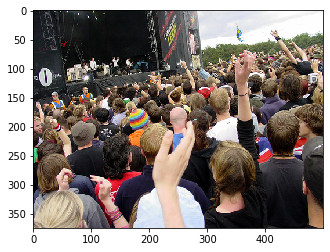

Greedy: group of people are dancing in front of crowd


In [87]:
z=4966
pic = list(encoding_train.keys())[z]
image = encoding_train[pic].reshape((1,2048))
x=plt.imread('flickr30k_images/flickr30k_images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
